In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
# Load the data
data = pd.read_csv('Organized_Data.csv', parse_dates=['Datetime'])
data.set_index('Datetime', inplace=True)

In [4]:
data = data.dropna()
data = data[180:]

In [5]:
# Extract features and labels
X = data.drop(columns=['nb_persons_SH'])
y = data['nb_persons_SH']

In [6]:
split_index = int(len(X) * 0.9)
X_train, X_valid = X[:split_index], X[split_index:]
y_train, y_valid = y[:split_index], y[split_index:]

In [16]:
ouai, oui = 1, 2

In [7]:
# Define sequence length
sequence_length = 10

# Normalize/Standardize data
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_valid = (X_valid - np.mean(X_valid, axis=0)) / np.std(X_valid, axis=0)

# Verify unique class values in y_train and y_valid
unique_classes = np.unique(np.concatenate([y_train, y_valid]))
num_classes = len(unique_classes)

# Function to create overlapping sequences
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

# Create sequences
X_train_sequences = create_sequences(X_train, sequence_length)
X_valid_sequences = create_sequences(X_valid, sequence_length)

# Create corresponding target values (using the last value in each sequence)
y_train_sequences = y_train[sequence_length - 1:]
y_valid_sequences = y_valid[sequence_length - 1:]

# Convert target values to categorical for multiclass classification
y_train_sequences_cat = to_categorical(y_train_sequences, num_classes=num_classes)
y_valid_sequences_cat = to_categorical(y_valid_sequences, num_classes=num_classes)



In [8]:
model_cla = Sequential([
    Input(shape=(sequence_length, X_train.shape[1])),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(128)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_cla.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_cla.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 10, 128)        │        39,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │           187 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,859 (1.23 MB)

 Trainable params: 322,347 (1.23 MB)

 Non-trainable params: 512 (2.00 KB)

In [9]:
# Train the model
model_cla.fit(X_train_sequences, y_train_sequences, 
          epochs=500, validation_data=(X_valid_sequences, y_valid_sequences), 
          batch_size=32)

In [10]:
loss, accuracy = model_cla.evaluate(X_valid_sequences, y_valid_sequences_cat)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


predictions = model_cla.predict(X_valid_sequences)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_valid_sequences_cat, axis=1)


accuracy = accuracy_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes, average='macro')

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0601 - loss: 2.3854  
Test Loss: 2.388174295425415
Test Accuracy: 0.06666667014360428
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Accuracy: 0.06666666666666667
F1 Score: 0.044398117392586284


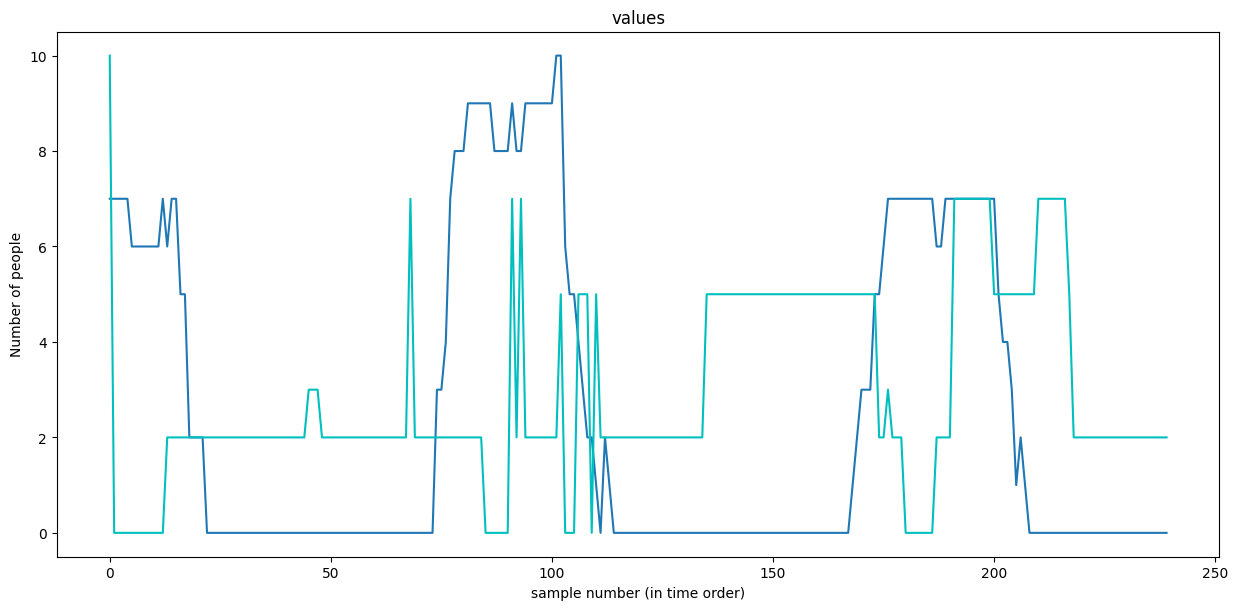

In [11]:
#plot figures:
plt.figure(figsize=(15,15))
plt.subplot(2, 1, 1)
plt.plot(true_classes)
plt.plot(predicted_classes,color='c')
plt.title('values')
plt.xlabel('sample number (in time order)')
plt.ylabel('Number of people')
"real values"
"predicted values"
plt.show()

In [12]:
# Save the entire model to a keras file
# model_cla.save('LSTM_cla_model_1.keras')

# Regression model

In [13]:
model_reg = Sequential([
    Input(shape=(sequence_length, X_train.shape[1])),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(128)),
    # Bidirectional(LSTM(256)),
    BatchNormalization(),
    # Dropout(0.5),
    Dense(64, activation='relu'),
    # Dropout(0.5),
    Dense(34, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(2, activation='relu'),
    Dense(1, activation='relu')
])

model_reg.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_reg.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 10, 128)        │        39,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 34)             │         2,210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 324,107 (1.24 MB)

 Trainable params: 323,595 (1.23 MB)

 Non-trainable params: 512 (2.00 KB)

In [14]:
# Train the model
model_reg.fit(X_train_sequences, y_train_sequences, 
          epochs=500, validation_data=(X_valid_sequences, y_valid_sequences), 
          batch_size=32)

Epoch 1/500


c:\Users\Charles\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6861 - loss: nan

c:\Users\Charles\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6862 - loss: nan - val_accuracy: 0.5792 - val_loss: nan
Epoch 2/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6685 - loss: nan - val_accuracy: 0.5792 - val_loss: nan
Epoch 3/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7066 - loss: nan - val_accuracy: 0.5792 - val_loss: nan
Epoch 4/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6869 - loss: nan - val_accuracy: 0.5792 - val_loss: nan
Epoch 5/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6869 - loss: nan - val_accuracy: 0.5792 - val_loss: nan
Epoch 6/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6876 - loss: nan - val_accuracy: 0.5792 - val_loss: nan
Epoch 7/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6890 - loss: nan - val_accuracy: 0.5792 - val_loss: nan
Epoch 8/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7019 - loss: nan - val_accuracy: 0.5792 - val_loss: nan
Epoch 9/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9

In [15]:
# Evaluate the model
loss = model_reg.evaluate(X_valid_sequences, y_valid_sequences)
print(f'Test Loss: {loss}')

# Predict and compare with actual values
predictions = model_reg.predict(X_valid_sequences)

mae = mean_absolute_error(y_valid_sequences, predictions)
mse = mean_squared_error(y_valid_sequences, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid_sequences, predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5464 - loss: nan 
Test Loss: [nan, 0.5791666507720947]
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Mean Absolute Error (MAE): 2.5375
Mean Squared Error (MSE): 17.720833333333335
Root Mean Squared Error (RMSE): 4.209612016959916
R-squared (R2): -0.5707275186623146


In [28]:
# Save the entire model to a keras file
# model_reg.save('LSTM_reg_model_1.keras')

: 